## Modules

In [674]:
# Data Wrangling
import pandas as pd
import numpy as np
from re import search


# Data preprocessing
from sklearn.feature_selection import SelectKBest, f_regression

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.colors as mcolors

# Pre processing and modeling
from sklearn.impute import SimpleImputer
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, roc_auc_score
import statsmodels.api as sm

# Configs
import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Functions

def NormalTest(var):
    #D’Agostino, R. and Pearson
    from scipy import stats
    k2, p = stats.normaltest(var)
    print("p = {:g}".format(p))
    alpha = 0.01
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

## Problem 01

King Joffrey Baratheon is about to marry Margaery Tyrell. To celebrate such an event, 1000 barrels of wine are going to be needed for the party. Nevertheless, when the servants in charge of bringing the wine went for the barrels, they found an intruder carrying an empty poisson vial large enough to poisson just one barrel with him.

The current queen, Cersei Lannister, was informed. The first step taken was the immediate death of the intruder. However, every possibility of retrieving any information on the poisoned barrel died with him.

Fortunately, you are a data scientist in service of His Majesty the King and you may experiment with any of the 10 prisoners in the dungeon.

Assuming that:

- Each prisoner may have at most one cup of wine.
- You may prepare cups with any combination of wines from the 1000 barrels.
- If a prisoner drinks from a cup containing any amount of wine from the poisoned barrel, he will die instantly.

Devise a methodology that allows us to find which of the barrels is poisoned… and do it before the wedding starts!

#### Answer

As each prisoner can only drink one cup of wine, the first step is to label each barrel from 0 to 999 (1000 barrels), and to make the following combination for each cup of wine:

- For prisoner one, he is given the cup with the following combination of barrels: 0,2,4,6.... (one barrel yes and one no).
- For prisoner two, he is given the cup with the following combination of barrels: 0,1,4,5... (every two barrels). (every two barrels)
- ...
- So on and so forth until prisoner 10 drinks from the cup with the combination (every 513 barrels).

With this combination, we have managed to perform a binary coding, where according to the state of each prisoner (1 = alive) and (0 = dead) we will be able to determine the origin of the poisoned barrel.

This way we will give his majesty the information of the infected barrel:

In [697]:
def StatePrisoners(P1,P2,P3,P4,P5,P6,P7,P8,P9,P10):
    BarrelInfected = (P1*(2**0)) + (P2*(2**1)) + (P3*(2**2)) + (P4*(2**3)) + (P5*(2**4)) + (P6*(2**5)) + (P7*(2**6)) + (P8*(2**7)) + (P9*(2**8)) + (P10*(2**9))
    return BarrelInfected

Assuming that:
- Prisoner 1 lives
- Prisoner 2 dies
- Prisoner 3 lives
- Prisoner 4 dies
- Prisoner 5 dies
- Prisoner 6 lives
- Prisoner 7 lives
- Prisoner 8 dies
- Prisoner 9 dies
- Prisoner 10 dies

Then:

In [699]:
StatePrisoners(P1= 1,P2= 0,P3= 1,P4= 0,P5= 0,P6= 0,P7= 1,P8= 0,P9= 0,P10= 0)

69

With this we know that with this combination of states, **the 69th barrel** is the poisoned one.

Your Majesty, don't forget to invite the Data Scientist and his team please!

##  Problem 02

There is a list of 1045 time series that correspond to several KPIs of different brands: from sales figures, average prices, to equity and awareness metrics.

Explain why your clusters choose to put these two time series in the same (or different) group in a qualitative way. (This means, explain to the client, a non-techincal person, why they are in the same or different group).

### Data Wrangling

In [150]:
url = ('https://raw.githubusercontent.com/Duhart/diagnosis_data/5c188f4b49cab406960b532b8c01cb346c618afa/time_series.csv')
TS = pd.read_csv(url, header=0, parse_dates=[2], index_col=2, squeeze=True)

$EMA$  with  $\alpha = \frac{11}{12}$ and  $SMA$  $12$:

$y_{t}= \begin{cases}\frac{1}{12} \sum_{t=1}^{12} x_{t} & \text { for } t=1 \\ \frac{11}{12} y_{t-1}+\frac{1}{12} x_{t} & \text { for } t>1\end{cases}$

In [3]:
#Smoothing algorithm to all series.
BrandMetricTS = pd.DataFrame()
for Brand in TS.Brand.unique():
    for Metric in  TS.Metric.unique(): #Aplying alg by Metric and Brand
        Brand_Metric_Selection = TS.loc[(TS.Brand == Brand) & (TS.Metric == Metric),'Measured_value']
        REWM_TS = pd.DataFrame(Brand_Metric_Selection.rolling(12).mean().dropna().ewm(alpha=11/12,adjust=False).mean())
        REWM_TS['Brand_Metric'] = Brand + ': ' + Metric
        BrandMetricTS = BrandMetricTS.append(REWM_TS)

In [4]:
BrandMetricTS  = BrandMetricTS.pivot(columns = 'Brand_Metric',values='Measured_value')

In [5]:
# Deleting huge number of series with more than 0.3 NaN
PercentNaN = BrandMetricTS.isna().sum(axis=0) /  BrandMetricTS.shape[0]
PercentNaN = pd.DataFrame(PercentNaN.sort_values(ascending=True),columns = ['P'])
PercentNaN =PercentNaN.P[PercentNaN.P < 0.3].index.values

BrandMetricTS = BrandMetricTS[PercentNaN]

In [6]:
# Simple imputer (MEAN)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(BrandMetricTS)
SimpleImputer()
BrandMetricTS = pd.DataFrame(imp_mean.transform(BrandMetricTS),index=BrandMetricTS.index,columns=BrandMetricTS.columns)

In [7]:
#Scaling
BrandMetricTS = BrandMetricTS.T

X = to_time_series_dataset(BrandMetricTS)
X = TimeSeriesScalerMeanVariance().fit_transform(X)

### Modeling

In [51]:
#Applying TimeSeriesKmeans with DTW
km = TimeSeriesKMeans(n_clusters=10, metric="dtw",n_init=15)
labels = km.fit_predict(X)

silhouette_score(X,labels, metric='dtw')

0.052729609783544774

The silhouette score gives a slightly low positive value, which indicates that the model has **matched** some neighboring clusters well.

In [11]:
# Joining Brand Metrics with clusters
BrandMetricTS = BrandMetricTS.T
Cluster = pd.DataFrame(labels,index= BrandMetricTS.columns,columns=['Cluster'])

BrandMetricTS = BrandMetricTS.join(Cluster)

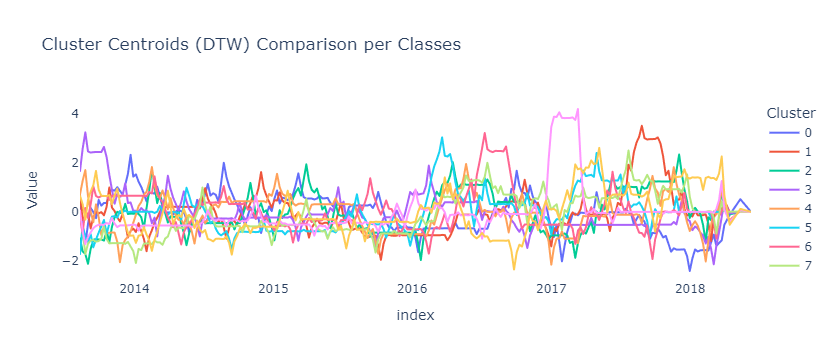

In [68]:
# Visualizing Cluster Centroids
Clusters = pd.DataFrame()
for i in range(0,10):
    ClusterCentroid = pd.concat([ pd.DataFrame(km.cluster_centers_[i].ravel()) , pd.DataFrame(np.repeat(i,km.cluster_centers_[i].ravel().shape[0])) ],axis=1).set_index(BrandMetricTS.index.drop('Cluster'))
    Clusters = pd.concat([Clusters,ClusterCentroid],axis = 0)
Clusters.columns = ['Value','Cluster']

fig = px.line(Clusters, x=Clusters.index, y='Value', color='Cluster', title='Cluster Centroids (DTW) Comparison per Classes ')
fig.update_layout(
    showlegend=True,
    plot_bgcolor="white",
    #margin=dict(t=10,l=10,b=10,r=10)
)
fig.show()

It is observed that the centroids with the TWD metric have notable differences which may indicate different behaviors for the 10 suggested groups. 

Now we proceed to analyze if *Waterman* and *Crowdchoice* for the metric *'For the people who know about drinks wanting something more special than usual'* belong to the same cluster.

In [110]:
Variables =[var for var in BrandMetricTS.index if search('Watermen: For the people who know about drinks wanting something more special than usual|Crowdchoice: For the people who know about drinks wanting something more special than usual',var)]

In [113]:
BrandMetricTS.loc[Variables,'Cluster']

Watermen: For the people who know about drinks wanting something more special than usual       5
Crowdchoice: For the people who know about drinks wanting something more special than usual    5
Name: Cluster, dtype: int64

This confirms that both belong to the same cluster **(5)** . It will be visually corroborated below that they do in fact have a similar pattern in common (in proportion and at a slight offset).

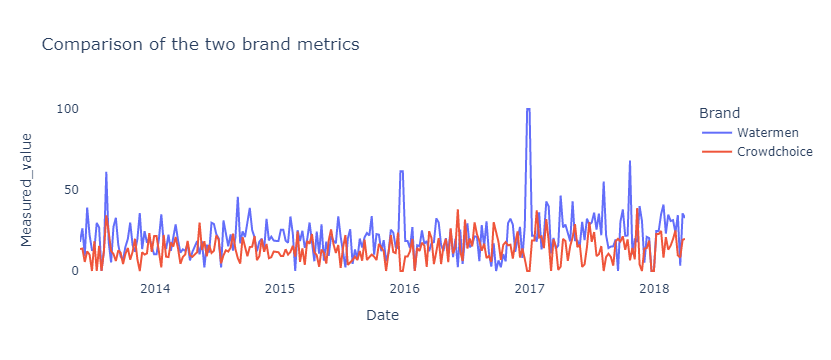

In [ ]:
# Comparison of the two brand metrics
TwoBrands = TS.loc[(TS.Brand.str.match(pat='Crowdchoice|Watermen')) & (TS.Metric.str.match(pat='For the people who know about drinks')),['Brand','Measured_value']]

fig = px.line(TwoBrands, x=TwoBrands.index, y='Measured_value', color='Brand', title='Comparison of the two brand metrics')
fig.update_layout(
    showlegend=True,
    plot_bgcolor="white")

### Results

**Qualitative Results**

As can be seen visually and after corroborating that the metric 'For people who know about drinks wanting something more special than usual' for the Crowdchoice and Watermen brands belong to the same group (using Kmeans with DTW distance).

This confirms for both brands that the market maintains the same perception of this metric (in different proportions), which may suggest that both have generated through their strategies the same results for the perception of the revised metric.

## Problem 03

There is a client that has collected among its many brands, information for several years about the revenue it collects each week and the investment done on TV and digital.

The client has now the budget for the next three weeks: $B1=200$, $B2=800$, and $B3=1600$. For each of these cases, device a model that allows us to decide what proportion of the budget to invest on TV and how much to invest in digital as to optimise the revenue each week.

In [410]:
# Data generation
url = ('https://raw.githubusercontent.com/Duhart/diagnosis_data/5c188f4b49cab406960b532b8c01cb346c618afa/media_optimisation.csv')
MediaOpt = pd.read_csv(url, header=0, squeeze=True)

### Exploratory Data Analysis

It can be seen at a general level that both TV and digital spend on average the same. And that revenue is maintained at twice as much. A fact that predicts a normal distribution behavior for the predictors is that their means and medians are close; we will validate this later on.

In [174]:
MediaOpt.describe()

,tv,digital,revenue
count,10000.000000,10000.000000,10000.000000
mean,498.940227,497.040989,877.022603
std,290.727014,289.477292,507.005804
min,0.238897,0.026354,0.000382
25%,245.179942,239.916329,514.484351
50%,499.837388,499.970987,866.622832
75%,750.693460,745.741763,1239.551588
max,999.831244,999.992479,1913.009756


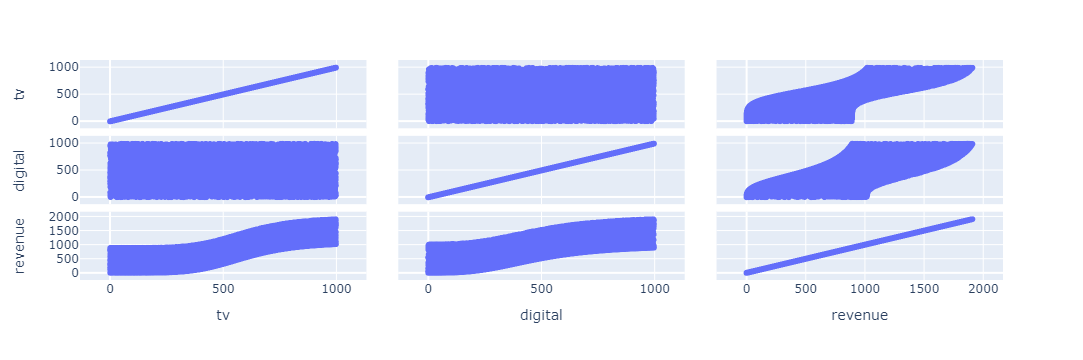

In [175]:
#SCATER MATRIX
fig = px.scatter_matrix(MediaOpt)
fig.show()

In [168]:
MediaOpt.corr()

,tv,digital,revenue
tv,1.000000,-0.001307,0.742788
digital,-0.001307,1.000000,0.629662
revenue,0.742788,0.629662,1.000000


Here we can see that there is a very well defined correlation between the predictors and revenue, which suggests the use of linear regression. (In turn, the fact that revenue and TV have a low correlation may help us to rule out multicollinearity).

In [195]:
NormalTest(var=MediaOpt.tv)

p = 0.795275
The null hypothesis cannot be rejected


In [197]:
NormalTest(var=MediaOpt.digital)

p = 0.795275
The null hypothesis cannot be rejected


In [200]:
NormalTest(var=MediaOpt.revenue)

p = 0.795275
The null hypothesis cannot be rejected


All predictor variables and our target meet the **normality criteria** so we will proceed to perform a linear regression to estimate the budgets.

### Modeling

In [411]:
# Segmenting regressor variables and target 
X = MediaOpt[[x for x in MediaOpt.columns if x!='revenue']]
y = MediaOpt['revenue']

In [412]:
# Verification of regression power scores of the variables
kb = SelectKBest(k="all", score_func=f_regression)

kb.fit(X, y)

df_scores = pd.DataFrame(data=zip(X.columns, kb.scores_), columns=["feature", "score"]).set_index("feature").sort_values(by="score", ascending=False)
df_scores

,score
feature,
tv,12305.749287
digital,6567.980180


The SelectKBest method shows that the scores for both variables have good predictive power for our target, so we are going to proceed to choose both.

In [413]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### MODEL 01

In [350]:
# Modeling
linreg = LinearRegression()
linreg.fit(X_train, y_train)

linreg.score(X_train, y_train)

0.9498867968876639

We have obtained a good $R^2$ explaining almost the total variance explained, we will perform a cross validation and review of the test data to validate if our model is consistent.

**Cross-validation**

In [351]:
ls_res = cross_val_score(X=X_train, y=y_train, estimator=linreg, cv=10, scoring="r2", n_jobs=-1)
ls_res

ls_res.mean(), ls_res.std()

(0.9497080687884638, 0.0030345961497262267)

On average, our model is consistent, as it maintains a good score with low standard deviation.

**Validación en test** : Our golden test

In [352]:
linreg.score(X_test, y_test)

0.9483283940876275

Not over adjusting :) this is great. Before proceeding, let's review some more performance metrics.

In [353]:
y_pred = linreg.predict(X_test)

print('r2_score test: ',r2_score(y_true=y_test, y_pred=y_pred))
print('MAPE test:', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE test:', mean_absolute_error(y_true=y_test, y_pred=y_pred))

r2_score test:  0.9483283940876275
MAPE test: 500.8665821227575
MAE test: 94.50385551956622


The MAPE is somewhat high, let's see if we can improve this estimate.

#### MODEL 02

In [256]:
from sklearn.model_selection import GridSearchCV

parameters =  {'alpha': np.linspace(0, 100, num=500) , "fit_intercept": [True, False]}

# define the model/ estimator
ridreg = Ridge()

# define the grid search
ridregplus = GridSearchCV(ridreg, parameters,cv=5)

#fit the grid search
ridregplus.fit(X_train,y_train)

# best estimator
print(ridregplus.best_score_)

# best model
best_model = ridregplus.best_estimator_
best_model.fit(X_train,y_train)

0.9492451978426141


Ridge(alpha=100.0)

In [270]:
y_pred = best_model.predict(X_test)

print('r2_score test: ',r2_score(y_true=y_test, y_pred=y_pred))
print('MAPE test:', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print('MAE test:', mean_absolute_error(y_true=y_test, y_pred=y_pred))

r2_score test:  0.9495496920724845
MAPE test: 23.035432954744135
MAE test: 93.37995553498199


Ridge suggests that the linear regression model without regularization is sufficient to proceed. Just for fun, we will analyze whether there are interactions between the two predictor variables.

#### Optimization Problem

In [415]:
X_train = sm.add_constant(X_train, prepend=True)
model = sm.OLS(endog=y_train, exog=X_train,)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 6.622e+04
Date:                Tue, 01 Feb 2022   Prob (F-statistic):               0.00
Time:                        01:42:47   Log-Likelihood:                -43087.
No. Observations:                7000   AIC:                         8.618e+04
Df Residuals:                    6997   BIC:                         8.620e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -317.8730      3.566    -89.134      0.0

The p-value of both regressor variables indicate that they are highly significant, as well as the intercept (which indicates that if we do not invest in ads we would not have revenue), so ideally we should invest in both variables. 

In [419]:
df_res = pd.DataFrame(data=zip(X_train.columns[1:3], linreg.coef_), columns=["feature", "weight"])

df_res.sort_values(by="weight")

,feature,weight
1,digital,1.103525
0,tv,1.292928


In [420]:
linreg.intercept_

-316.86065282711047

Since the model has a linear relationship, it subtracts solving a linear optimization problem with the budgets:
$revenue   = -315.03 + 1.28 \times TV + 1.09 \times digital  $

In [421]:
def OptimalBudget(Budget):

    from pulp import LpProblem,LpMaximize,LpVariable,LpStatus

    #Budget = 200

    #Max Budger
    prob = LpProblem("Ads Sales Problem", LpMaximize)

    #tv <= Budget
    x = LpVariable("x", 0, Budget/2)

    #revenue <= Budget
    y = LpVariable("y", 0, Budget/2)

    #Should be less than $Budget
    prob += x + y  <= Budget

    coef = linreg.coef_
    prob += coef.item(0) * x + coef.item(1) * y + linreg.intercept_

    print('Resolution Problem: ',LpStatus[prob.solve()])

    for v in prob.variables():
        print(v.name, "=", np.round(v.varValue,0))

    print("Objective Revenue = %f" % (prob.objective.value()))

### Results

In [422]:
OptimalBudget(Budget=200)

Resolution Problem:  Optimal
x = 100.0
y = 100.0
Objective Revenue = -77.215435


In [423]:
OptimalBudget(Budget=800)

Resolution Problem:  Optimal
x = 400.0
y = 400.0
Objective Revenue = 641.720217


In [438]:
OptimalBudget(Budget=1600)

Resolution Problem:  Optimal
x = 800.0
y = 800.0
Objective Revenue = 1600.301087


As they say: **'It's better not to put all your eggs in one basket'**. In this case, assuming that we should invest in both variables (since both were significant for the model), the result shows that we should invest in both variables equally for the different weeks. At the same time it is recommended to the client not to generate investments below approximately **$300**, since unfavorable revenues will be obtained.

## Problem 04

The State of Guanajuato has a population of 6 million. A client has a website that only operates on the state and in this month, the website had 3 million visits.

During this month, they took a sample of 400 people and asked them how many times a day they used the internet (frequency) and how long (in minutes) on average they use the internet every time they use it. They claim that the longer they use the internet the easier would be for a user to click through their website.

Device an algorithm to classify who in the sample clicked through the website and if they did, estimate how many times they clicked it.

In [536]:
# Data generation
url = ('https://raw.githubusercontent.com/Duhart/diagnosis_data/master/media_exposure.csv')
WebSite = pd.read_csv(url, header=0, squeeze=True,index_col='ID')

### Exploratory Data Analysis

We create a third variable that will indicate the average absolute time spent on the Internet browsing.

In [537]:
WebSite['total_usage'] =  WebSite['freq'] * WebSite['freq']

In [538]:
WebSite.describe()

,freq,usage,total_usage
count,400.000000,400.000000,400.000000
mean,3.032500,18.657500,15.897500
std,2.591957,22.532965,27.499045
min,0.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000
50%,3.000000,11.000000,9.000000
75%,4.000000,26.000000,16.000000
max,17.000000,127.000000,289.000000


For our sample, it is observed that on average users access the Internet 3 times a day.

And on average they use the internet between 11 - 18 minutes per occasion.

However, the total time spent on the Internet suggests that the total time spent on the Internet is less on average than if it were a single occasion.

In [673]:
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

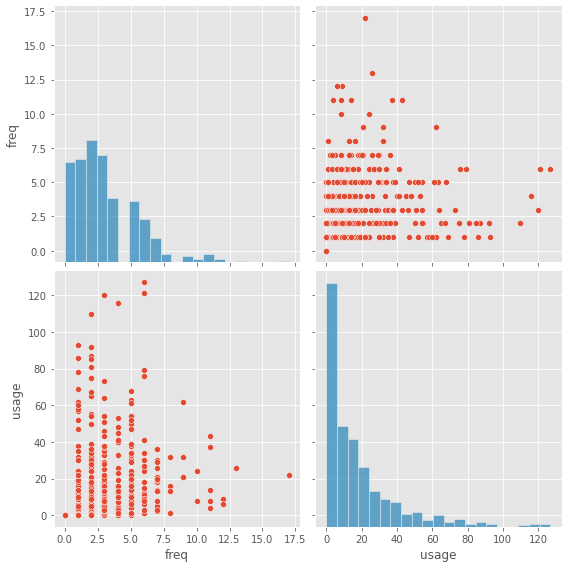

In [540]:
sb.pairplot(WebSite,size=4,vars=["freq","usage"],kind='scatter')

There does not seem to be any kind of grouping or correlation between users.

Since we don't have the number of clicks, we can perform a clustering using Kmeans to divide our data into n classes (depending they enter the page or not) according to the client's premise 'the more they use the Internet, the more they visit our page' and make a decision range. Therefore, we will proceed to use the Mahalanobis distance for correlations between both variables.

In [541]:
WebSite = WebSite.drop('total_usage',1)

In [542]:
std = StandardScaler()
std.fit(WebSite)

WebSite = pd.DataFrame(std.transform(WebSite),index=WebSite.index,columns=WebSite.columns)
X = np.array(WebSite[['freq','usage']])

In [482]:
#X =  WebSite.drop('total_usage',1)
#X = np.array(WebSite[['freq','usage']])

In [543]:
kmeans = KMeans(n_clusters=6,random_state=19950803)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=19950803)

In [544]:
WebSite = pd.DataFrame(std.inverse_transform(WebSite),index=WebSite.index,columns=WebSite.columns)
WebSite = WebSite.join( pd.DataFrame(kmeans.labels_.astype('str'),index=WebSite.index,columns=['Label']))

In [545]:
clusterCentroids = pd.DataFrame(std.inverse_transform(kmeans.cluster_centers_),columns=['freq','usage'])

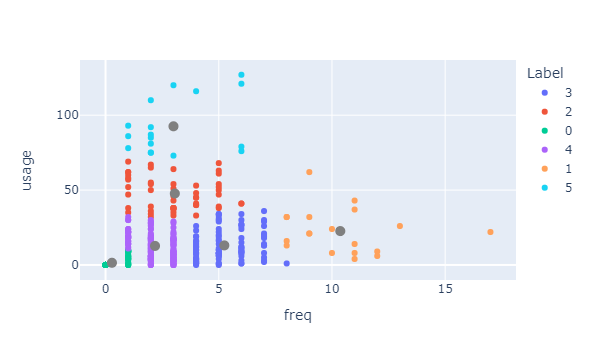

In [546]:
import plotly.express as px
fig = px.scatter(WebSite, x='freq', y='usage', color="Label")
fig.add_traces(px.scatter(clusterCentroids, x="freq", y="usage").update_traces(marker_size=10, marker_color="gray").data)
fig.show()

In [547]:
clusterCentroids['total'] = clusterCentroids['freq'] * clusterCentroids['usage']

In [548]:
clusterCentroids = clusterCentroids.sort_values('total')
#clusterCentroids.index = [2,1,0,1]
clusterCentroids

,freq,usage,total
0,0.282353,1.482353,0.418547
4,2.185185,12.733333,27.824691
3,5.244681,13.063830,68.515618
2,3.060000,47.720000,146.023200
1,10.368421,22.631579,234.653740
5,3.000000,92.588235,277.764706


In [549]:
WebSite.Label.value_counts().sort_values()

5     17
1     19
2     50
0     85
3     94
4    135
Name: Label, dtype: int64

We observe that it is with six groups that we can make a proportional representation to the behavior of the population (derived from the fact that the population is 6m vs. 3m who click on the page) representing 50%. Similarly, following the client's premise 'the more internet usage, the more likely they are to click', so by taking groups 5,1,2 and 3 (taking as a criterion their centroids of selection) we obtain approximately half of our sample that has the highest internet usage. That is to say:

In [569]:
print('Percentage of people who use the Internet the most: ',WebSite.loc[WebSite.Label.astype('int').isin([1,2,3,5]),'Label'].shape[0] / WebSite.shape[0] * 100,'%')

Percentage of people who use the Internet the most:  45.0 %


With this we proceed to segment our sample into two 0 does not click and 1 clicks, based on the clusters we chose.

In [598]:
WebSite.loc[WebSite.Label.astype('int').isin([1,2,3,5]),'Label'] = 1
WebSite.loc[WebSite.Label.astype('int').isin([0,4]),'Label'] = 0

### Modeling

In [572]:
X = WebSite[['freq','usage']]
y = WebSite[['Label']].astype('int')

In [588]:
logreg = LogisticRegression(max_iter=1000,random_state=19950308)

**Train-test split**

In [589]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

**Training Model**

In [590]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=19950308)

**Cross validation**

In [591]:
ls_scores = cross_val_score(X=X_train, y=y_train, cv=4, n_jobs=-1, estimator=logreg, scoring="roc_auc")

In [592]:
ls_scores.mean(), ls_scores.std()

(0.990157819225251, 0.002542987145081785)

**Test Performance**

In [597]:
print('ROC TEST: ' , roc_auc_score(y_true=y_test, y_score=logreg.predict(X_test)))

ROC TEST:  0.9708538587848933


It is clear that as we divide our classes artificially we can have a good performance, however we now have a model (logistic regression) that allows us to obtain an estimate of clicks based on the premise of our cl. Now with this model we can proceed to generate the estimated number of clicks for our entire sample:

### Results

Now that we have our model trained we proceed to determine the number of clicks assuming as a hypothesis that for every time the user enters the internet they can enter the page.

In [601]:
WebSite = WebSite.drop('Label',axis = 1) # We delete artificial labels

In [651]:
WebSite['Enter_Page'] = logreg.predict(WebSite)

WebSite['Prob_Enter'] = logreg.predict_proba(WebSite[['freq', 'usage']])[:,1].round(2)

In [659]:
WebSite.sample(5)

,freq,usage,Enter_Page,Prob_Enter
ID,,,,
182,2.0,13.0,0,0.03
164,4.0,16.0,1,0.93
172,1.0,69.0,1,0.95
223,2.0,17.0,0,0.05
238,11.0,37.0,1,1.00


Being $1$ enter the page and $0$  do not enter. We will $estimate$ the $frequency$ with which users entered the page by multiplying the frequency of internet use by the probability of entering the page and we will make zero those who did not enter the page. That is:

In [665]:
WebSite['NoTimesLogIntoSite'] = (WebSite['freq'] * WebSite['Prob_Enter']).astype('int') * WebSite['Enter_Page'] 

In [670]:
WebSite.sample(5)

,freq,usage,Enter_Page,Prob_Enter,NoTimesLogIntoSite
ID,,,,,
234,8.0,32.0,1,1.00,8
385,3.0,38.0,1,0.97,2
207,3.0,9.0,0,0.19,0
152,1.0,19.0,0,0.00,0
275,5.0,34.0,1,1.00,5


With this we now have a method to estimate whether or not a user has entered the page and a criterion to determine how many times they has done so.

## Personal section

*Thank you in advance for the possibility of considering me for this vacancy. I hope you find my results interesting, I would appreciate your feedback.*

*Regardless of the result, I dare say that I found this test a very interesting challenge.*

*Thank you very much in advance and I hope to keep in touch with you.*

*My linkedIn:* [Josué Axel López de la O](https://www.linkedin.com/in/josue-alo/)